# MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y=mnist["data"].values, mnist["target"].values
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


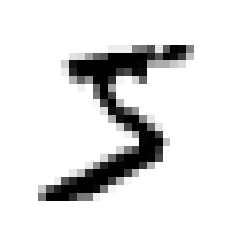

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np
y=y.astype(np.uint8)

MNISTデータセットは訓練データ(はじめの60000)とテストデータ(残り10000)に分かれており、シャッフルされている

In [6]:
X_train, X_test, y_train, y_test=X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [7]:
y_train_5 = (y_train==5)
y_test_5=(y_test==5)

[SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html): 確率的勾配降下法

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

## Measuring Accuracy Using Cross-Validation

chap02で行なったcross_val_scoreを求める。

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

このスコアは一見いいように見えるが、比較のため5と判定しない分類器を作る。

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [12]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

常に5ではないと予想しても90%の正解(5は1/10だから)。

分類問題ではaccuracyは好ましくない。

# Confusion Matrix

[cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict): 交差検証による予測を行う

交差検証のため、予測値を求める。

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

[confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix): 混合行列を求める

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

完全な分類器なら混合行列は対角成分のみになる。

In [15]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

precision(適合率):
$$
precision=\frac{TP}{TP+FP}
$$

recall(再現率):
$$
recall=\frac{TP}{TP+FN}
$$

In [16]:
from sklearn.metrics import precision_score, recall_score
print('precision:',precision_score(y_train_5, y_train_pred))

print('recall:',recall_score(y_train_5, y_train_pred))


precision: 0.8370879772350012
recall: 0.6511713705958311


F1:
$$
F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}
$$

In [17]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


## Precision/Recall Trade-off

[decision_function](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function): 信頼スコア(距離に比例)の予測

In [18]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

しきい値を増やすとrecallが減少する。

In [21]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

[precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_precision_recall_curve.html#sklearn.metrics.plot_precision_recall_curve): precision/recallをplot、1.0でdepricated

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds=precision_recall_curve(y_train_5, y_scores)

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlim(-50000,50000)
    plt.xlabel('Threshold')


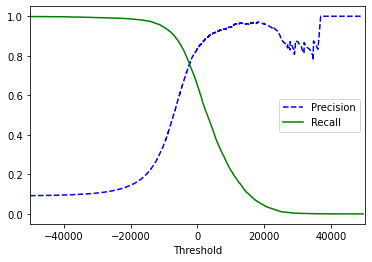

In [24]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Text(0, 0.5, 'Precision')

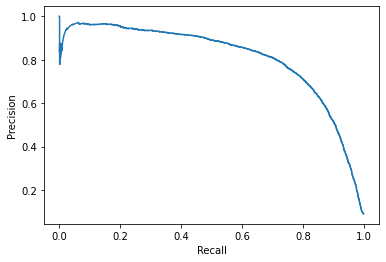

In [25]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [26]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [27]:
y_train_pred_90=(y_scores>=threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))
      

0.9000345901072293
0.4799852425751706


## The ROC Curve

[roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve): しきい値に対してTPR(true positive rate)とFPR(false positive rate)を求める。

真陽性率(recall:再現率)
$$
TPR=recall=\frac{TP}{TP+FN}
$$

偽陽性率
$$
FPR=\frac{FP}{FP+TN}=1-specificity
$$

特異度
$$
specificity=\frac{TN}{FP+TN}
$$

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')

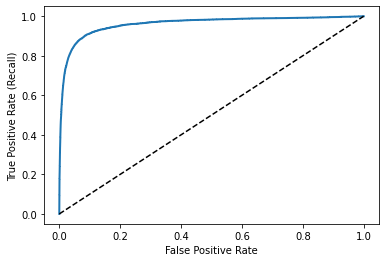

In [31]:
plot_roc_curve(fpr, tpr)

AUC(area under the curve)の比較。完全な分類器ではROC AUCは1になり純粋にランダムな分類器では0.5になる。

[roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score): 予測値からROC AUCを計算。

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

[ランダムフォレスト](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)との比較。

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method='predict_proba')

In [33]:
y_scores_forest=y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

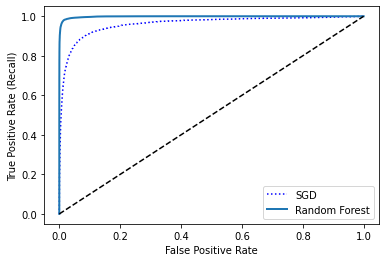

In [34]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

precision/recallの算出

In [44]:
p_forest, r_forest, t_forest=precision_recall_curve(y_train_5, y_scores_forest)

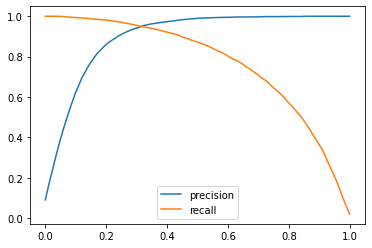

In [47]:
plt.plot(t_forest, p_forest[:-1], label= "precision")
plt.plot(t_forest, r_forest[:-1], label ="recall")
plt.legend()

precisionが99%になるしきい値

In [50]:
threshold_99_precision=t_forest[np.argmax(p_forest>=0.99)]
threshold_99_precision

0.51

In [51]:
y_train_pred_99=(y_scores_forest>=threshold_99_precision)
print(precision_score(y_train_5, y_train_pred_99))
print(recall_score(y_train_5, y_train_pred_99))
      

0.9905083315756169
0.8662608374838591


# Multiclass Classification

OvR(one versus the rest): 分類したいクラスの数だけ２値分類器を訓練しそれぞれのスコアから予測値を得る。

OVO(one versus one): 2値分類器を各クラスのペアごとに訓練。N個のクラスがあった場合、N(N-1)/2の分類器ができる。MNISTの場合45個。

sklearnはどちらを実行するか自動で選ぶ(アルゴリズム次第)。

[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC): C-Support Vector Classification

In [52]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

SVCでは内部的にはOvOを用いている。

In [53]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

最大のスコアのインデックスが予測したクラスとなる。

In [54]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


[OvO](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)や[OvR](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier)を強制することもできる。


In [55]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
len(ovr_clf.estimators_)

10

SGDやランダムフォレストはより簡単。SGDでは直接多クラス分類をするのでOvRやOvOを実行する必要はない。

In [62]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

テキストと違い3と予測してしまう。

In [63]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

ランダムな分類器なら10%の精度になるため、まぁまぁの結果。

入力値を[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)でスケーリングすることでさらに精度向上する。

In [60]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

モデルの改善のため、エラーの種類を解析する。

混合行列の確認、可視化。

In [64]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

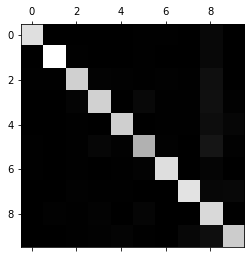

In [65]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

エラーにフォーカスする。データセット内の各ラベルの画像数が同じでないので画像数で割って割合にする。

In [66]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

対角成分を0にしてエラー成分を強調。

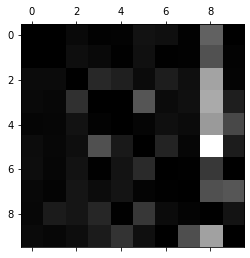

In [67]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

行(row)が実際の値、列(column)が予測値。８列が明るくなっているが、8行は暗いため、８を予測することを間違っている訳ではない。３や５を混同しやすいらしい。

３と5について、成功・失敗の例を確認する。

In [68]:
cl_a, cl_b=3,5
X_aa=X_train[(y_train == cl_a) & (y_train_pred==cl_a)]
X_ab=X_train[(y_train == cl_a) & (y_train_pred==cl_b)]
X_ba=X_train[(y_train == cl_b) & (y_train_pred==cl_a)]
X_bb=X_train[(y_train == cl_b) & (y_train_pred==cl_b)]

In [72]:
def plot_digits(instances, images_per_row=10, **options):
    size=28
    images_per_row=min(len(instances), images_per_row)
    n_rows=(len(instances)-1)//images_per_row +1
    
    n_empty=n_rows*images_per_row-len(instances)
    padded_instances=np.concatenate([instances, np.zeros((n_empty, size*size))], axis=0)
    
    image_grid=padded_instances.reshape((n_rows, images_per_row, size, size))
    
    big_image=image_grid.transpose(0,2,1,3).reshape(n_rows*size, images_per_row * size)
    
    plt.imshow(big_image, cmap=plt.cm.gray, **options)
    plt.axis("off")

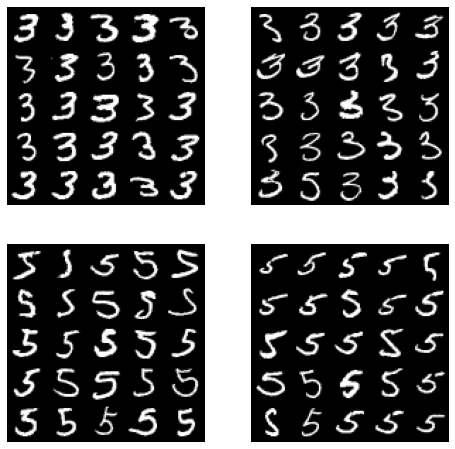

In [73]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

左側の２つは"3"と分類、右側の２つは"5"と分類。右上と左下が誤判定したものになる。

ほとんどが明らかに間違っているが、なぜ間違ったかは分からない。現状は単純な線形モデルで分類しているだけ。３と５は数ピクセルの違いしかないため間違えやすい。

# Multilabel Classification

一つの画像から複数のものが写っていてそれらを全て検出したい場合など。

y>=7と奇数という二つのラベルを作る。

[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier): k近傍法

この分類器はマルチラベルに対応しているが、全ての分類器が対応しているわけではない。

In [74]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train %2 ==1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [75]:
knn_clf.predict([some_digit])

/home/tuffy/venvs/.ml/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

some_digit=5なので正解。

評価方法としてF1を各ラベルについて求め、その平均を出してみる。

In [76]:
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

/home/tuffy/venvs/.ml/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/tuffy/venvs/.ml/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accept

0.976410265560605

# Multioutput Classification

マルチラベルで多クラスの分類。

ノイズを除去するシステムを作る。ピクセルと同じだけラベルがあり、256階調なので多クラスということになる。

In [77]:
noise=np.random.randint(0,100, (len(X_train), 784))
X_train_mod=X_train + noise
noise=np.random.randint(0,100, (len(X_test), 784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [79]:
def plot_digit(some_digit):
    digit_image=some_digit.reshape(28,28)
    
    plt.imshow(digit_image, cmap='binary')
    plt.axis=('off')

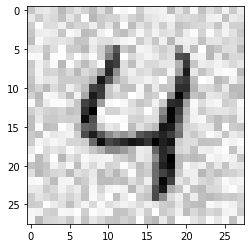

In [95]:
some_index= 4
plot_digit(X_test_mod[some_index])


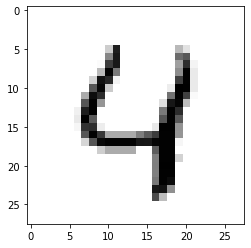

In [96]:
plot_digit(y_test_mod[some_index])

/home/tuffy/venvs/.ml/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


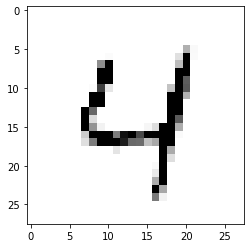

In [97]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)